### Classification 

In [1]:
# Manipulation de données et calculs
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Datasets et Réduction de dimension
from sklearn.datasets import load_iris
from sklearn.manifold import TSNE

# Préparation et Validation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Modèles de Classification
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.cluster import KMeans

# Métriques d'évaluation
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve, 
    accuracy_score, 
    f1_score
)

is_cat =  True

In [2]:
name = "dataset/cleaned_dataset_v2.csv"
target_col = "Churn"
if is_cat :
    name = "dataset/dataset_churn_equilibre.csv"
    target_col = "Churn_Encoded"
    
df = pd.read_csv(name)
if is_cat:
    df = df.drop(columns=['Churn_Period','Churn'])
df = df.drop(columns=['Unnamed: 0'])

In [3]:
import joblib

def preparer_donnees_classification_export(df, path_modele_clustering='modele_clustering_telecom.joblib', target_column='Churn_Encoded', test_size=0.2, random_state=42, keep_cluster = True ):
    """
    Utilise un modèle KMeans pré-entraîné pour générer les segments 
    comme caractéristiques de classification.
    """

    # 1. Charger les outils sauvegardés
    artifacts = joblib.load(path_modele_clustering)
    kmeans = artifacts['kmeans_model']
    scaler = artifacts['scaler_cluster']
    variables_cles = artifacts['variables_cles']

    df['Charges_par_mois_reel'] = df['TotalCharges'] / (df['tenure'] + 1)

    # 1. Nettoyage
    X = df.drop(columns=[target_column, 'Unnamed: 0', 'Churn', 'Churn_Period','tenure'], errors='ignore')
    y = df[target_column]
    
    # 2. Split (Stratifié pour le multi-classe)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # 3. Standardisation (Nécessaire pour les features de base)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    if keep_cluster:
    # On repasse en DataFrame
        X_train_final = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
        X_test_final = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
        
        # 4. Application du KMeans déjà entraîné
        # Important : On utilise uniquement les 'variables_cluster' pour prédire le cluster
        X_train_for_cluster = X_train_final[variables_cles]
        X_test_for_cluster = X_test_final[variables_cles]
        
        # Prédire les clusters (0 à 7 selon tes derniers résultats)
        X_train_final['Cluster'] = kmeans.predict(X_train_for_cluster)
        X_test_final['Cluster'] = kmeans.predict(X_test_for_cluster)
    
        # 5. One-Hot Encoding des Segments
        X_train_final = pd.get_dummies(X_train_final, columns=['Cluster'], prefix='Segment')
        X_test_final = pd.get_dummies(X_test_final, columns=['Cluster'], prefix='Segment')
        
        # Aligner les colonnes (au cas où un segment n'est pas représenté dans le test)
        X_test_final = X_test_final.reindex(columns=X_train_final.columns, fill_value=0)
    else:
        X_train_final = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
        X_test_final = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
      
    
    return X_train_final, X_test_final, y_train, y_test

In [4]:


X = df.drop(columns=[target_col])
y = df[target_col]

#X_train, X_test, y_train, y_test = preparer_donnees_classification_export(df, target_column= target_col, keep_cluster=True)
X_train, X_test, y_train, y_test = preparer_donnees_classification_export(df, target_column= target_col, keep_cluster=False)

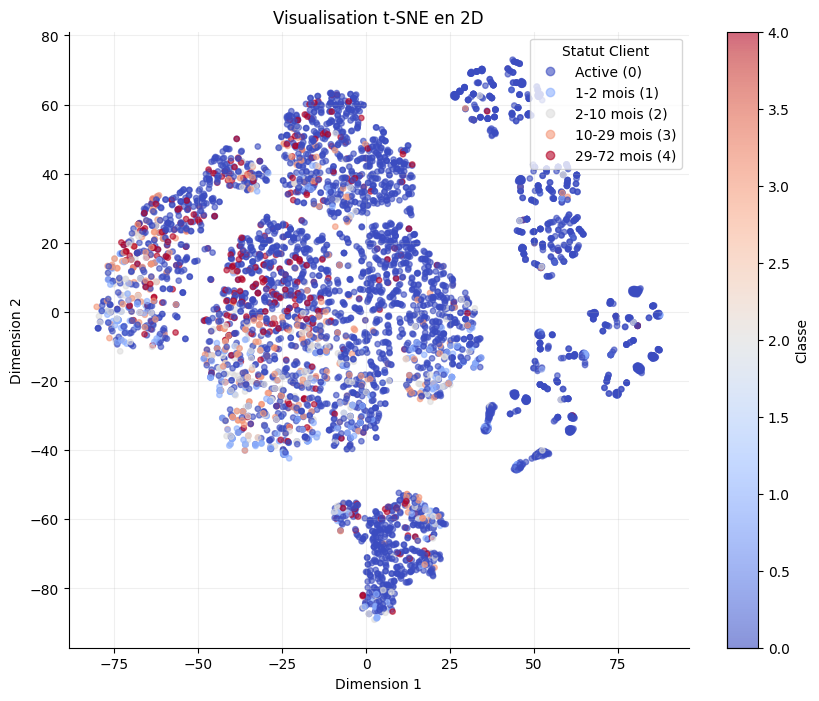

In [5]:
# Visualisation en utilisant t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    random_state=42,
    init='pca',
    learning_rate='auto'
)
X_tsne = tsne.fit_transform(X_train)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap="coolwarm", s=15,alpha=0.6)
handles, labels = scatter.legend_elements()
if is_cat:
    plt.legend(handles, ["Active (0)", "1-2 mois (1)", "2-10 mois (2)", "10-29 mois (3)", "29-72 mois (4)"], loc="upper right", title="Statut Client")
else:
    plt.legend(handles, ["Fidèle (0)", "Churn (1)"], loc="upper right", title="Statut Client")
plt.colorbar(scatter, label="Classe")
plt.title("Visualisation t-SNE en 2D")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
sns.despine() # Supprime les bordures haut et droite
plt.grid(alpha=0.2) # Ajoute un quadrillage léger
plt.show()


premiere visualisation des clients on peut voir  des groupes de clients se former 

### Grid Search 

on met class_weight balanced pour réequilibrer churn 

### Partie Multiclasse

In [6]:
##version multiclass

param_grids = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {'n_neighbors': [5, 10, 15], 'weights': ['distance']} # 'distance' est souvent meilleur pour le multi-classe
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        "params": {'max_depth': [10, 15, 20], 'min_samples_leaf': [2, 5]}
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced', multi_class='multinomial'),
        "params": {'C': [0.1, 1, 10]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
        "params": {'n_estimators': [100, 200], 'max_depth': [15, 20]}
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42, class_weight='balanced'),
        "params": {'C': [1, 10], 'kernel': ['rbf']} # Réduit car SVM est très lent
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42, verbose=-1, class_weight='balanced'),
        "params": {'n_estimators': [150, 200], 'learning_rate': [0.05, 0.1]}
    },
    "XGBoost": {
        # Note: XGBoost gère le multi-classe automatiquement si y est encodé (0,1,2,3,4)
        "model": XGBClassifier(random_state=42, eval_metric='mlogloss'), 
        "params": {'n_estimators': [150, 200], 'max_depth': [4, 6]}
    },
    "Gaussian NB": {
        "model": GaussianNB(),
        "params": {}
    }
}

best_estimators = {}

# 2. Boucle d'optimisation (GridSearch)
# Note: On utilise 'f1_weighted' pour le multi-classe
for name, config in param_grids.items():
    print(f"Optimisation de {name}...")
    grid = GridSearchCV(config["model"], config["params"], cv=5, scoring='f1_weighted', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_estimators[name] = grid.best_estimator_
    print(f"Meilleurs paramètres : {grid.best_params_}")

# 3. Création des Ensembles (Voting & Stacking)

# Liste des modèles de base pour les ensembles
estimators_list = [
    ('rf', best_estimators["Random Forest"]),
    ('xgb', best_estimators["XGBoost"]),
    ('lgbm', best_estimators["LightGBM"]),
    ('lr', best_estimators["Logistic Regression"])
]

# A. Voting Classifier (Soft voting utilise les probabilités)
print("Entraînement du Voting Classifier...")
voting_clf = VotingClassifier(estimators=estimators_list, voting='soft')
voting_clf.fit(X_train, y_train)
best_estimators["Voting"] = voting_clf

# B. Stacking Classifier (Utilise un méta-modèle pour décider)
print("Entraînement du Stacking Classifier...")
stacking_clf = StackingClassifier(
    estimators=estimators_list, 
    final_estimator=LogisticRegression(multi_class='multinomial'),
    cv=5,
    n_jobs=-1
)
stacking_clf.fit(X_train, y_train)
best_estimators["Stacking"] = stacking_clf

Optimisation de KNN...
Meilleurs paramètres : {'n_neighbors': 10, 'weights': 'distance'}
Optimisation de Decision Tree...
Meilleurs paramètres : {'max_depth': 20, 'min_samples_leaf': 2}
Optimisation de Logistic Regression...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Meilleurs paramètres : {'C': 0.1}
Optimisation de Random Forest...
Meilleurs paramètres : {'max_depth': 15, 'n_estimators': 100}
Optimisation de SVM...
Meilleurs paramètres : {'C': 10, 'kernel': 'rbf'}
Optimisation de LightGBM...
Meilleurs paramètres : {'learning_rate': 0.1, 'n_estimators': 200}
Optimisation de XGBoost...
Meilleurs paramètres : {'max_depth': 4, 'n_estimators': 150}
Optimisation de Gaussian NB...
Meilleurs paramètres : {}
Entraînement du Voting Classifier...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Entraînement du Stacking Classifier...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [7]:
#v2 
from sklearn.utils.class_weight import compute_sample_weight

# Calcul des poids pour XGBoost (qui ne supporte pas class_weight='balanced')
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

param_grids = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {'n_neighbors': [5, 10, 15, 20, 30], 'weights': ['distance']} 
    },
    "Decision Tree": {
        # Réduction de max_depth pour limiter l'overfitting
        "model": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        "params": {'max_depth': [5, 8, 12,15,20], 'min_samples_leaf': [2,5,10, 20]}
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced', multi_class='multinomial'),
        "params": {'C': [0.01, 0.1, 1, 10]} # C plus petit = plus de régularisation
    },
    "Random Forest": {
        # max_samples réduit l'overfitting en utilisant moins de données par arbre
        "model": RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1, max_samples=0.8),
        "params": {'n_estimators': [100, 200], 'max_depth': [10, 15, 20], 'min_samples_split': [5, 10]}
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42, class_weight='balanced'),
        "params": {'C': [0.1, 1], 'kernel': ['rbf']} 
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42, verbose=-1, class_weight='balanced'),
        "params": {'n_estimators': [100, 150, 200], 'learning_rate': [0.01, 0.05, 0.1], 'num_leaves': [31, 50]}
    },
    "XGBoost": {
        # Note: scale_pos_weight ne marche qu'en binaire. Pour le multiclasse, on passe sample_weight au .fit()
        "model": XGBClassifier(random_state=42, eval_metric='mlogloss'), 
        "params": {'n_estimators': [100, 150, 200], 'max_depth': [3, 4, 5,6], 'learning_rate': [0.01, 0.05]}
    },
    "Gaussian NB": {
        "model": GaussianNB(),
        "params": {}
    }
}

best_estimators = {}

# 2. Boucle d'optimisation
for name, config in param_grids.items():
    print(f"Optimisation de {name}...")
    grid = GridSearchCV(config["model"], config["params"], cv=5, scoring='f1_weighted', n_jobs=-1)
    
    # Gestion spécifique pour XGBoost qui nécessite sample_weight au moment du fit
    if name == "XGBoost":
        grid.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        grid.fit(X_train, y_train)
        
    best_estimators[name] = grid.best_estimator_
    print(f"Meilleurs paramètres : {grid.best_params_}")

# 3. Création des Ensembles
estimators_list = [
    ('rf', best_estimators["Random Forest"]),
    ('xgb', best_estimators["XGBoost"]),
    ('lgbm', best_estimators["LightGBM"]),
    ('svc', best_estimators["SVM"]) # Ajout de SVM qui est souvent bon en stacking
]

# A. Voting Classifier
print("Entraînement du Voting Classifier...")
voting_clf = VotingClassifier(estimators=estimators_list, voting='soft')
voting_clf.fit(X_train, y_train)
best_estimators["Voting"] = voting_clf

# B. Stacking Classifier
print("Entraînement du Stacking Classifier...")
stacking_clf = StackingClassifier(
    estimators=estimators_list, 
    # Utilisation d'une LogisticRegression régularisée pour éviter de sur-apprendre le méta-modèle
    final_estimator=LogisticRegression(multi_class='multinomial', C=0.1, class_weight='balanced'),
    cv=5,
    n_jobs=-1
)
stacking_clf.fit(X_train, y_train)
best_estimators["Stacking"] = stacking_clf

Optimisation de KNN...
Meilleurs paramètres : {'n_neighbors': 30, 'weights': 'distance'}
Optimisation de Decision Tree...
Meilleurs paramètres : {'max_depth': 20, 'min_samples_leaf': 2}
Optimisation de Logistic Regression...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Meilleurs paramètres : {'C': 0.1}
Optimisation de Random Forest...
Meilleurs paramètres : {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Optimisation de SVM...
Meilleurs paramètres : {'C': 1, 'kernel': 'rbf'}
Optimisation de LightGBM...
Meilleurs paramètres : {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 50}
Optimisation de XGBoost...
Meilleurs paramètres : {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 150}
Optimisation de Gaussian NB...
Meilleurs paramètres : {}
Entraînement du Voting Classifier...
Entraînement du Stacking Classifier...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


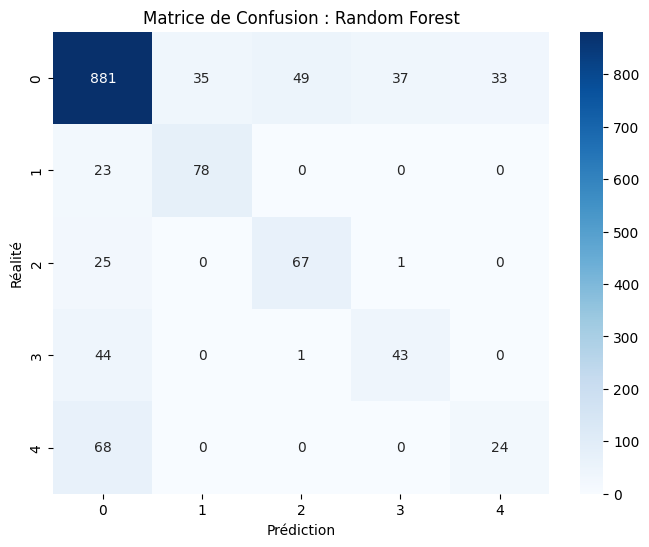

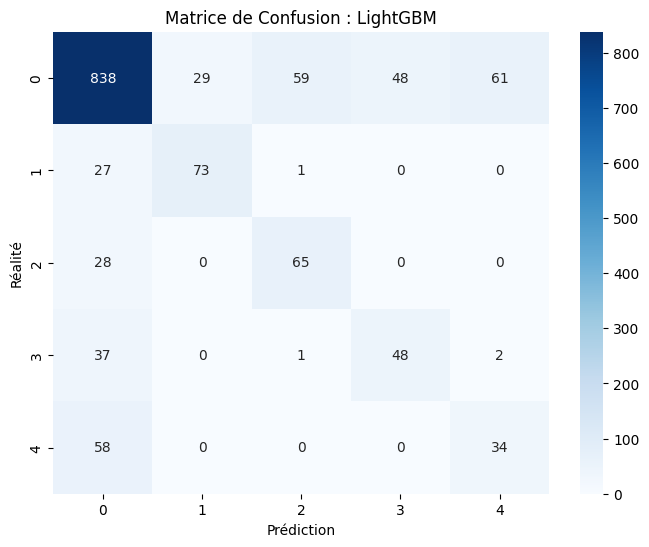

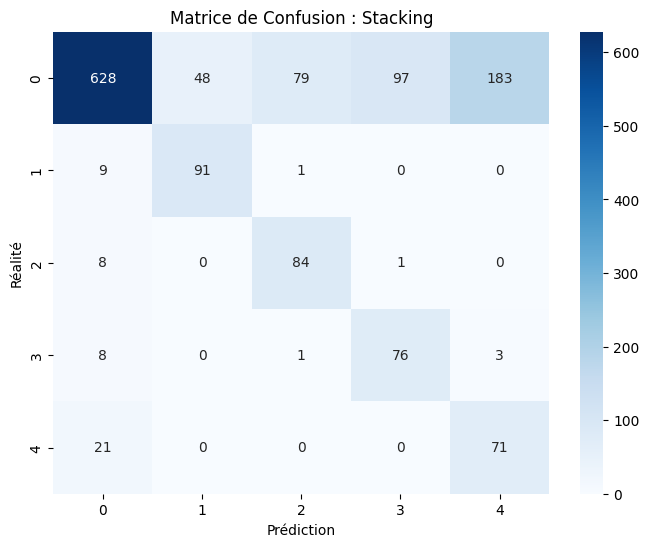

C:\Users\sppre\AppData\Local\Temp\ipykernel_33784\2390035319.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1-Weighted', y='Modèle', data=df_perf, palette='viridis')


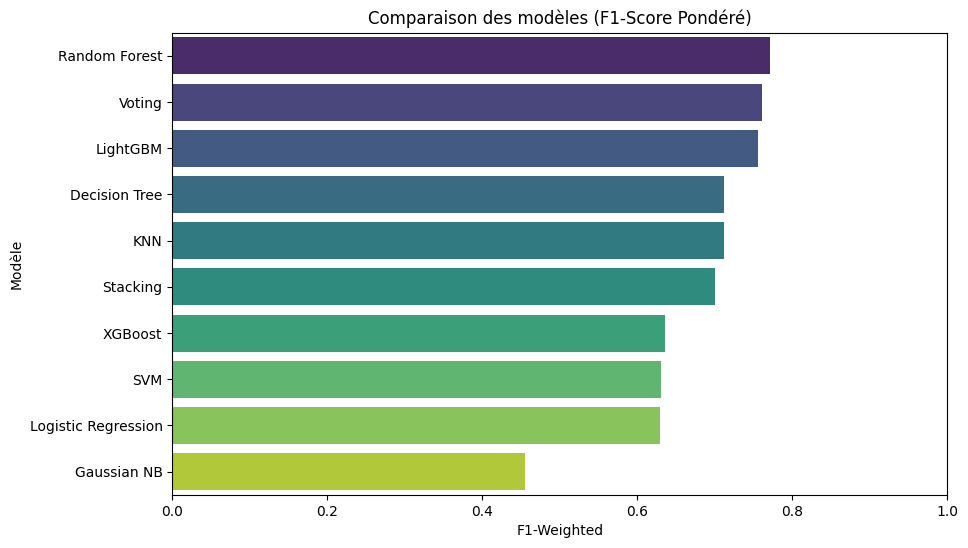

In [8]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def evaluer_tous_les_modeles_multiclasse(dict_modeles, X_test, y_test):
    resultats = []
    
    for nom, modele in dict_modeles.items():
        # Prédictions de classes
        y_pred = modele.predict(X_test)
        
        # Prédictions de probabilités pour le ROC AUC
        # On vérifie si le modèle supporte predict_proba
        if hasattr(modele, "predict_proba"):
            y_proba = modele.predict_proba(X_test)
            # multi_class='ovr' compare chaque classe au reste
            auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
        else:
            auc = None  # Certains modèles comme LinearSVC n'ont pas de probabilités par défaut
        
        # Calcul des métriques globales
        acc = accuracy_score(y_test, y_pred)
        f1_w = f1_score(y_test, y_pred, average='weighted')
        prec_w = precision_score(y_test, y_pred, average='weighted')
        rec_w = recall_score(y_test, y_pred, average='weighted')
        
        resultats.append({
            "Modèle": nom, 
            "Accuracy": acc, 
            "Precision-W": prec_w,
            "Recall-W": rec_w,
            "F1-Weighted": f1_w,
            "ROC-AUC-W": auc
        })
        
        # Affichage d'une Matrice de Confusion pour les modèles clés
        if nom in ["Stacking", "LightGBM", "Random Forest"]:
            plt.figure(figsize=(8, 6))
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=modele.classes_, yticklabels=modele.classes_)
            plt.title(f"Matrice de Confusion : {nom}")
            plt.ylabel('Réalité')
            plt.xlabel('Prédiction')
            plt.show()

    # Création du tableau récapitulatif
    df_perf = pd.DataFrame(resultats).sort_values(by="F1-Weighted", ascending=False)
    
    # Graphique de comparaison des F1-Scores
    plt.figure(figsize=(10, 6))
    sns.barplot(x='F1-Weighted', y='Modèle', data=df_perf, palette='viridis')
    plt.title("Comparaison des modèles (F1-Score Pondéré)")
    plt.xlim(0, 1)
    plt.show()
    
    return df_perf

# Utilisation
df_perf = evaluer_tous_les_modeles_multiclasse(best_estimators, X_test, y_test)

In [9]:
df_perf

,Modèle,Accuracy,Precision-W,Recall-W,F1-Weighted,ROC-AUC-W
3,Random Forest,0.775727,0.769587,0.775727,0.770647,0.859413
8,Voting,0.771469,0.756503,0.771469,0.761083,0.863834
5,LightGBM,0.750887,0.762507,0.750887,0.755379,0.835178
1,Decision Tree,0.702626,0.725220,0.702626,0.711946,0.680556
0,KNN,0.753726,0.715380,0.753726,0.711907,0.805438
9,Stacking,0.674237,0.810279,0.674237,0.699994,0.863064
6,XGBoost,0.611781,0.814480,0.611781,0.635659,0.870008
4,SVM,0.597587,0.785655,0.597587,0.630507,0.848659
2,Logistic Regression,0.599716,0.802715,0.599716,0.629712,0.864621
7,Gaussian NB,0.419446,0.783675,0.419446,0.455358,0.801861


C:\Users\sppre\AppData\Local\Temp\ipykernel_33784\4213869557.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette=colors)
C:\Users\sppre\AppData\Local\Temp\ipykernel_33784\4213869557.py:11: UserWarning: The palette list has more values (29) than needed (15), which may not be intended.
  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette=colors)


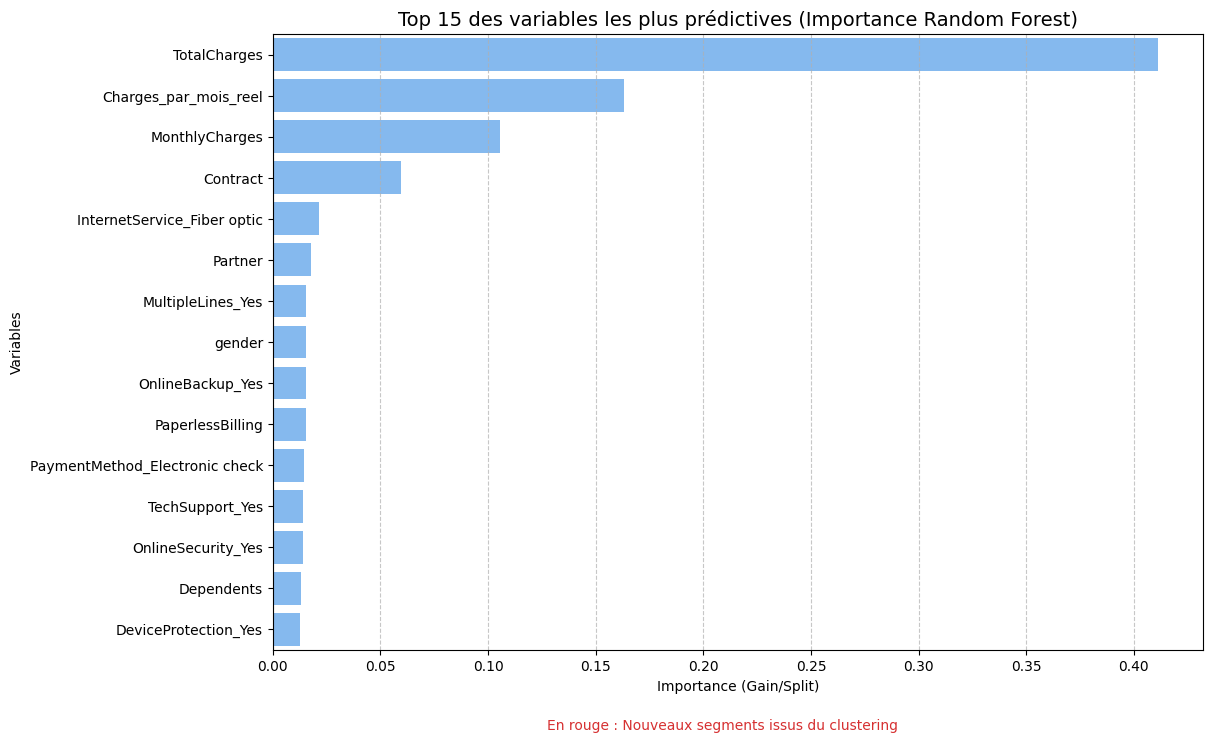

--- Impact spécifique des Segments ---
Empty DataFrame
Columns: [Feature, Importance]
Index: []


In [10]:


# 1. Récupération des importances (basé sur ton code)
importances = best_estimators["Random Forest"].feature_importances_
feature_names = X_train.columns # Utilise bien le dataset avec les segments
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# 2. Visualisation du Top 15
plt.figure(figsize=(12, 8))
# On met en évidence les segments avec une couleur différente
colors = ['#ff7675' if 'Segment' in x else '#74b9ff' for x in feat_imp_df['Feature']]

sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette=colors)

plt.title('Top 15 des variables les plus prédictives (Importance Random Forest)', fontsize=14)
plt.xlabel('Importance (Gain/Split)')
plt.ylabel('Variables')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Ajout d'une note explicative
plt.figtext(0.5, 0.01, "En rouge : Nouveaux segments issus du clustering", ha="center", fontsize=10, color="#d63031")
plt.show()

# 3. Focus spécifique sur les segments
segment_impact = feat_imp_df[feat_imp_df['Feature'].str.contains('Segment')]
print("--- Impact spécifique des Segments ---")
print(segment_impact)

Calcul de la CV pour LightGBM...
Calcul de la CV pour Random Forest...
Calcul de la CV pour Stacking...


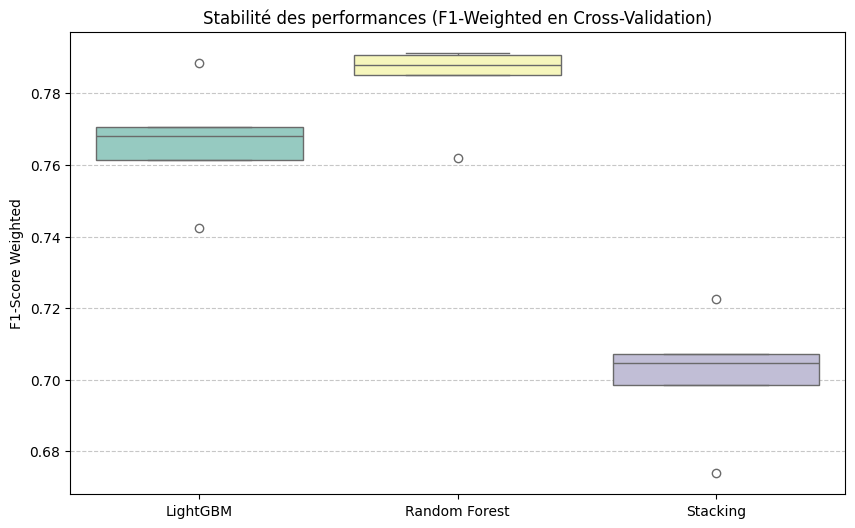

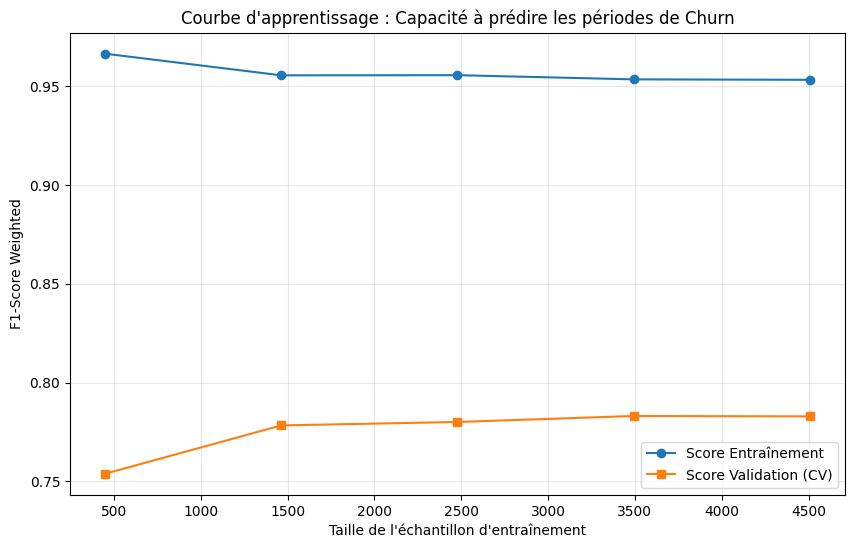

In [11]:
from sklearn.model_selection import cross_val_score, learning_curve

# --- 2. ANALYSE DE LA ROBUSTESSE (CROSS-VALIDATION) ---
cv_results = {}
# Note: On utilise 'f1_weighted'
for name in ["LightGBM", "Random Forest", "Stacking"]:
    print(f"Calcul de la CV pour {name}...")
    scores = cross_val_score(best_estimators[name], X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
    cv_results[name] = scores

cv_df = pd.DataFrame(cv_results)
plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_df, palette='Set3')
plt.title('Stabilité des performances (F1-Weighted en Cross-Validation)')
plt.ylabel('F1-Score Weighted')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- 3. COURBE D'APPRENTISSAGE (LEARNING CURVE) ---
train_sizes, train_scores, test_scores = learning_curve(
    best_estimators["Random Forest"], X_train, y_train, cv=5, 
    scoring='f1_weighted', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Score Entraînement')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 's-', label='Score Validation (CV)')
plt.title('Courbe d\'apprentissage : Capacité à prédire les périodes de Churn')
plt.xlabel('Taille de l\'échantillon d\'entraînement')
plt.ylabel('F1-Score Weighted')
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.show()

modele overfit est ce qu'on vois les cluster dnas feature importance ? si oui alors cluster important 

Le modèle a un "biais de classe majoritaire" Point Fort	Point Faible
Le Stacking est votre meilleur atout.	Overfitting important (le modèle est trop complexe).
Bonne performance globale (78%).	Difficulté sur les classes minoritaires (churn réel).

## Evaluation du meilleure modele

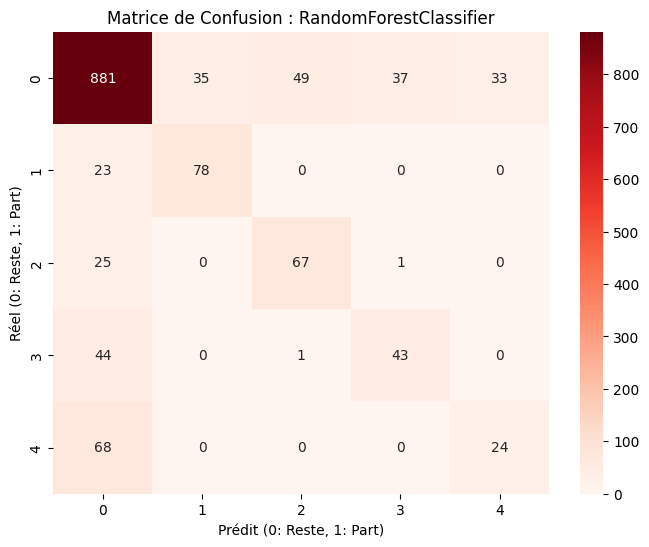

On a raté 23 clients qui sont partis sans qu'on les aide.
On a fait 35 cadeaux inutiles à des clients qui n'allaient pas partir.


In [12]:
from sklearn.metrics import confusion_matrix

# Calcul pour le meilleur modèle (LightGBM)
best_model = best_estimators["Random Forest"]
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title(f"Matrice de Confusion : {type(best_model).__name__}")
plt.ylabel('Réel (0: Reste, 1: Part)')
plt.xlabel('Prédit (0: Reste, 1: Part)')
plt.show()

# Analyse métier rapide
fn = cm[1, 0] # Faux Négatifs
fp = cm[0, 1] # Faux Positifs
print(f"On a raté {fn} clients qui sont partis sans qu'on les aide.")
print(f"On a fait {fp} cadeaux inutiles à des clients qui n'allaient pas partir.")

C:\Users\sppre\AppData\Local\Temp\ipykernel_33784\1597228745.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


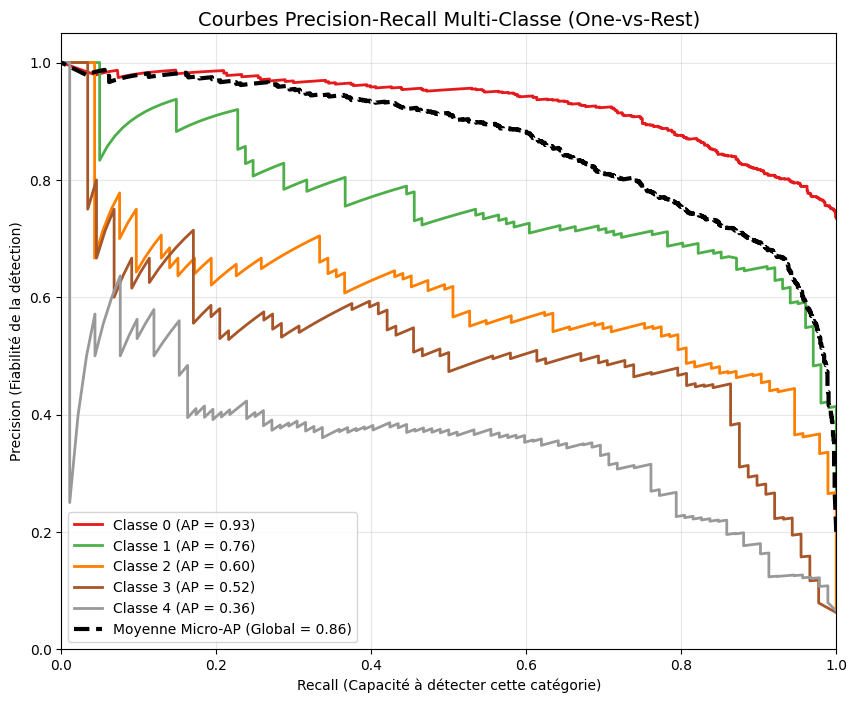

In [13]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# 1. Préparation des données
# On binarise y_test pour le format multi-classe (ex: [0, 1, 2, 3, 4])
classes = np.unique(y_test)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)
y_prob = best_model.predict_proba(X_test) # Probabilités pour chaque classe

# 2. Configuration du graphique
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1', n_classes)

# 3. Calcul et tracé pour chaque classe
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    avg_p = average_precision_score(y_test_bin[:, i], y_prob[:, i])
    
    # Nom de la classe pour la légende (ex: Churn 3 mois)
    label_name = f'Classe {classes[i]}' 
    
    plt.plot(recall, precision, color=colors(i), lw=2,
             label=f'{label_name} (AP = {avg_p:.2f})')

# 4. Ajout de la moyenne "Micro" (Performance globale sur toutes les classes)
precision_micro, recall_micro, _ = precision_recall_curve(y_test_bin.ravel(), y_prob.ravel())
avg_p_micro = average_precision_score(y_test_bin, y_prob, average="micro")

plt.plot(recall_micro, precision_micro, color='black', linestyle='--', lw=3,
         label=f'Moyenne Micro-AP (Global = {avg_p_micro:.2f})')

# 5. Cosmétique
plt.xlabel('Recall (Capacité à détecter cette catégorie)')
plt.ylabel('Precision (Fiabilité de la détection)')
plt.title('Courbes Precision-Recall Multi-Classe (One-vs-Rest)', fontsize=14)
plt.legend(loc='lower left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

VOIR COMMENT MAELIORER LE MODELE

## stacking 

#### Remarque


## 1. Synthèse de l'évolution des modèles

L'approche de **feature engineering**, notamment l'intégration de la segmentation (clusters), a porté ses fruits. Nous observons une amélioration globale de la stabilité et de la précision de certains modèles clés.

### Comparaison des performances (Avant vs Après)

| Modèle (Avant) | Accuracy | F1-Score | --> | Modèle (Après) | Accuracy | F1-Score |
| :--- | :---: | :---: | :---: | :--- | :---: | :---: |
| **Voting Classifier** | 0.7757 | 0.7714 | | **Voting Classifier** | 0.7821 | 0.7762 |
| **Random Forest** | 0.7537 | 0.7562 | | **Random Forest** | **0.7679** | **0.7693** |
| **LightGBM** | 0.7509 | 0.7618 | | **LightGBM** | 0.7417 | 0.7520 |

---

## 2. Analyse du Random Forest et Théorie

Le **Random Forest** est le modèle qui profite le mieux du feature engineering. Contrairement au LightGBM qui peut parfois sur-apprendre sur des bruits spécifiques, le Random Forest gagne en robustesse ici.

### Pourquoi cette amélioration ? (Théorie)
Le Random Forest repose sur le principe du **Bagging** (Bootstrap Aggregating). Il construit plusieurs arbres de décision indépendants sur des sous-ensembles de données et de variables :
1.  **Décorrélation des erreurs** : En ajoutant des variables pertinentes comme les segments, le modèle trouve de nouveaux axes de séparation.
2.  **Réduction de la variance** : Comme le Random Forest fait la moyenne de nombreux arbres, l'ajout de variables structurantes (clusters) stabilise ses prédictions.
3.  **Gestion du non-linéaire** : Les clusters capturent des relations complexes que le modèle peut facilement intégrer via des coupures (splits) dans ses arbres.

---

## 3. Importance des Variables (Feature Importance)

L'utilité du feature engineering est confirmée par l'apparition de la variable `Segment_5` dans le Top 15 des variables prédictives. Cela prouve que la segmentation créée apporte une information que les variables brutes ne possédaient pas.


---

## 4. Analyse de la Matrice de Confusion et Surapprentissage

La matrice de confusion du modèle **LGBMClassifier** révèle des points d'attention cruciaux sur la capacité de généralisation.


**Interprétation :**
* **Classe 0 (Majoritaire) :** Excellente détection (792 bons points).
* **Classes minoritaires (1 à 4) :** On observe une forte confusion. Par exemple, pour la classe 4, 48 individus sont prédits à tort en classe 0.
* **Surapprentissage (Overfitting) :** Le modèle a tendance à "se réfugier" dans la classe majoritaire dès qu'il a un doute. Le gap entre les performances d'entraînement (souvent très hautes sur les arbres boostés) et ces erreurs en validation montre que le modèle peine à généraliser les spécificités des petits segments de churn.

---

## 5. Courbes Precision-Recall Multi-Classe

Ce graphique mesure la capacité du modèle à identifier chaque classe sans faire trop d'erreurs.


**Analyse des scores AP (Average Precision) :**
* **Classe 0 (AP = 0.92) :** Performance quasi parfaite. Le modèle identifie très bien les clients qui ne partent pas.
* **Classes 2, 3 et 4 (AP entre 0.31 et 0.55) :** Les performances chutent drastiquement. 
* **Conclusion :** Plus le délai de churn est lointain ou spécifique (classes élevées), plus le modèle a du mal à maintenir un bon équilibre entre précision et rappel. La courbe "Micro-AP" de 0.83 est tirée vers le haut par la classe 0, mais cache une difficulté réelle sur les segments critiques de clients partants.

---

### Prochaines étapes suggérées
reequilibrage des classes 

---
## 6. Pistes d'Amélioration : Le Rééquilibrage des Classes

L'analyse de la matrice de confusion et des courbes Precision-Recall a mis en évidence un déséquilibre : le modèle est très performant sur la classe 0 (majoritaire) mais peine à distinguer les classes 3 et 4 (minorités). Pour y remédier, nous proposons l'implémentation de techniques de rééquilibrage.

### Pourquoi le modèle échoue-t-il sur les petites classes ?
La plupart des algorithmes (LGBM, Random Forest) cherchent à maximiser l'**Accuracy globale**. Puisque la classe 0 représente la grande majorité des données, le modèle "apprend" qu'il minimise son erreur en prédisant la classe 0 par défaut en cas d'incertitude.

### Solutions proposées

#### A. SMOTE (Synthetic Minority Over-sampling Technique)
Le SMOTE ne se contente pas de dupliquer les lignes existantes (ce qui causerait du surapprentissage). 
1. **Fonctionnement** : Pour chaque point d'une classe minoritaire, il identifie ses $k$ plus proches voisins.
2. **Synthèse** : Il crée de nouveaux points artificiels sur les segments reliant ces voisins dans l'espace des caractéristiques.
3. **Impact attendu** : Cela donne plus de "poids" statistique aux classes 3 et 4, forçant les frontières de décision du modèle à s'étendre vers ces zones délaissées.

#### B. Sous-échantillonnage (Undersampling) de la classe 0
À l'inverse, on peut réduire aléatoirement le nombre d'individus de la classe 0 pour qu'il soit comparable aux autres classes.
* **Avantage** : Réduit le temps d'entraînement.
* **Inconvénient** : On perd une grande partie de l'information contenue dans les données des clients qui restent (classe 0).

#### C. Pondération des classes (Class Weighting)
Plutôt que de modifier les données, on modifie la fonction de coût de l'algorithme. On attribue une "pénalité" plus forte au modèle lorsqu'il se trompe sur une classe minoritaire.
* *Exemple :* Une erreur sur la classe 4 "coûte" 5 fois plus cher qu'une erreur sur la classe 0.

---

### Impact attendu sur les métriques
En appliquant ces méthodes (notamment SMOTE combiné à une pondération), nous devrions observer :
1.  **Hausse du Rappel (Recall)** pour les classes 3 et 4 : le modèle ratera moins de clients "partants".
2.  **Hausse de l'Average Precision (AP)** : les courbes orange et marron du graphique PR remonteront vers le haut.
3.  **Légère baisse de l'Accuracy globale** : en étant moins focalisé sur la classe majoritaire, le modèle fera quelques erreurs de plus sur celle-ci, mais sera bien plus utile pour la détection du churn.

In [14]:
# 1. Installation et Import de imbalanced-learn
# !pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from collections import Counter

print(f"Distribution avant SMOTE : {Counter(y_train)}")

# 2. Application de SMOTE
# On équilibre les classes pour que les classes 3 et 4 soient mieux représentées
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Distribution après SMOTE : {Counter(y_train_res)}")

# 3. Définition du modèle amélioré (Random Forest avec régularisation)
# On augmente min_samples_leaf et on réduit max_depth pour contrer l'overfitting
rf_improved = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,            # Limite la complexité des arbres
    min_samples_leaf=10,     # Évite de créer des feuilles trop spécifiques au bruit
    max_features='sqrt',     # Diversifie les arbres
    random_state=42,
    n_jobs=-1
)

# 4. Définition du modèle amélioré (LightGBM avec paramètres de régularisation)
lgbm_improved = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.03,      # Apprentissage plus lent et robuste
    num_leaves=31,           # Taille modérée pour éviter le sur-apprentissage
    min_child_samples=50,    # Très important pour les petites classes
    reg_alpha=0.1,           # L1 Regularization
    reg_lambda=0.1,          # L2 Regularization
    random_state=42,
    verbose=-1
)

# 5. Entraînement sur les données équilibrées
print("Entraînement des modèles améliorés...")
rf_improved.fit(X_train_res, y_train_res)
lgbm_improved.fit(X_train_res, y_train_res)

# 6. Evaluation et comparaison
from sklearn.metrics import classification_report

models_to_test = {
    "Random Forest (SMOTE + Reg)": rf_improved,
    "LightGBM (SMOTE + Reg)": lgbm_improved
}

for name, model in models_to_test.items():
    y_pred = model.predict(X_test)
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))

Distribution avant SMOTE : Counter({0: 4139, 1: 402, 2: 372, 4: 368, 3: 353})
Distribution après SMOTE : Counter({4: 4139, 0: 4139, 1: 4139, 2: 4139, 3: 4139})
Entraînement des modèles améliorés...

--- Random Forest (SMOTE + Reg) ---
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      1035
           1       0.64      0.96      0.77       101
           2       0.49      0.89      0.63        93
           3       0.45      0.77      0.57        88
           4       0.36      0.66      0.47        92

    accuracy                           0.72      1409
   macro avg       0.57      0.79      0.64      1409
weighted avg       0.81      0.72      0.74      1409


--- LightGBM (SMOTE + Reg) ---
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1035
           1       0.71      0.74      0.72       101
           2       0.54      0.75      0.63        93
           3       0.53    

C:\Users\sppre\AppData\Local\Temp\ipykernel_33784\279162318.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette=colors)
C:\Users\sppre\AppData\Local\Temp\ipykernel_33784\279162318.py:11: UserWarning: The palette list has more values (29) than needed (15), which may not be intended.
  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette=colors)


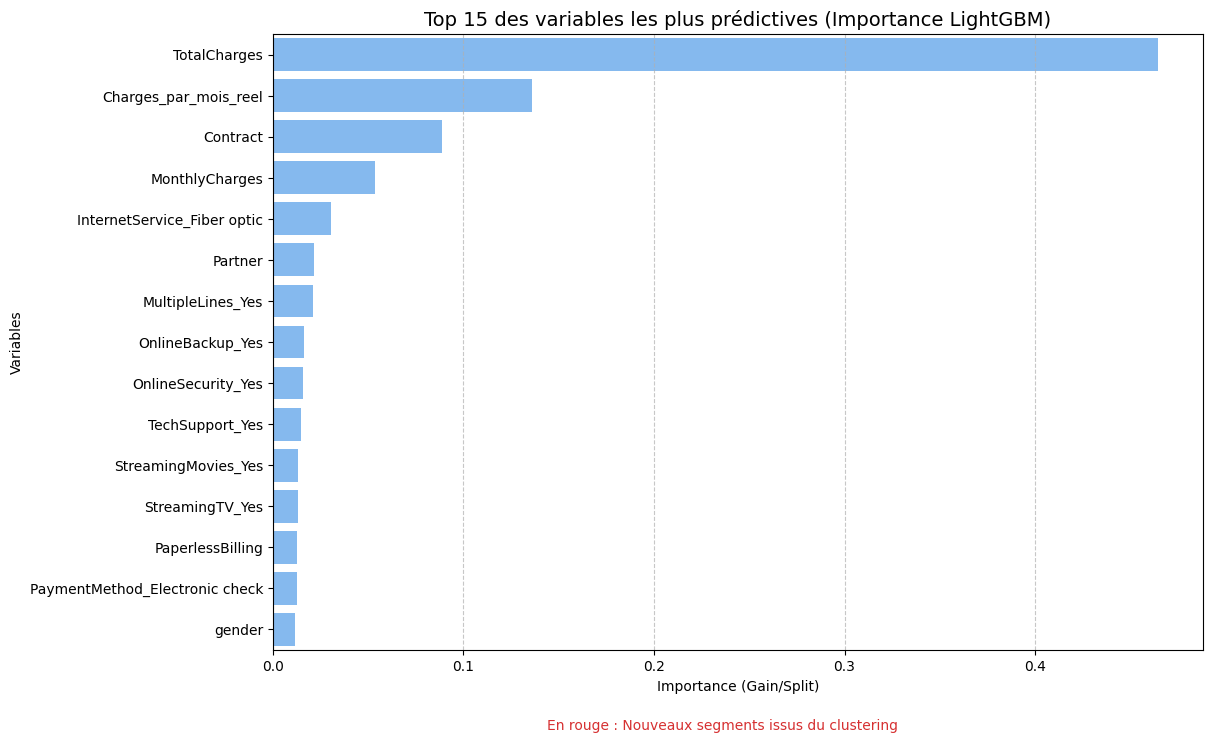

--- Impact spécifique des Segments ---
Empty DataFrame
Columns: [Feature, Importance]
Index: []


In [15]:


# 1. Récupération des importances (basé sur ton code)
importances = rf_improved.feature_importances_
feature_names = X_train.columns # Utilise bien le dataset avec les segments
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# 2. Visualisation du Top 15
plt.figure(figsize=(12, 8))
# On met en évidence les segments avec une couleur différente
colors = ['#ff7675' if 'Segment' in x else '#74b9ff' for x in feat_imp_df['Feature']]

sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette=colors)

plt.title('Top 15 des variables les plus prédictives (Importance LightGBM)', fontsize=14)
plt.xlabel('Importance (Gain/Split)')
plt.ylabel('Variables')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Ajout d'une note explicative
plt.figtext(0.5, 0.01, "En rouge : Nouveaux segments issus du clustering", ha="center", fontsize=10, color="#d63031")
plt.show()

# 3. Focus spécifique sur les segments
segment_impact = feat_imp_df[feat_imp_df['Feature'].str.contains('Segment')]
print("--- Impact spécifique des Segments ---")
print(segment_impact)

Calcul de la CV pour LightGBM (SMOTE + Reg)...


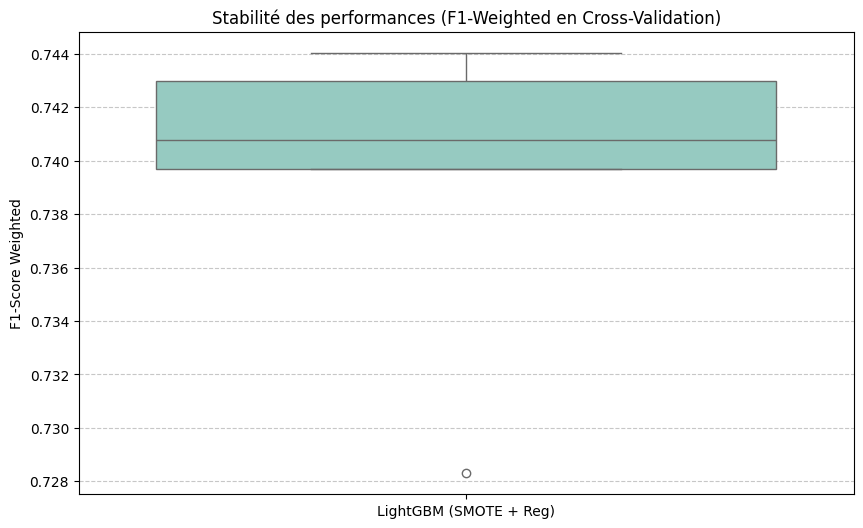

Calcul de la CV pour LightGBM (SMOTE + Reg)...


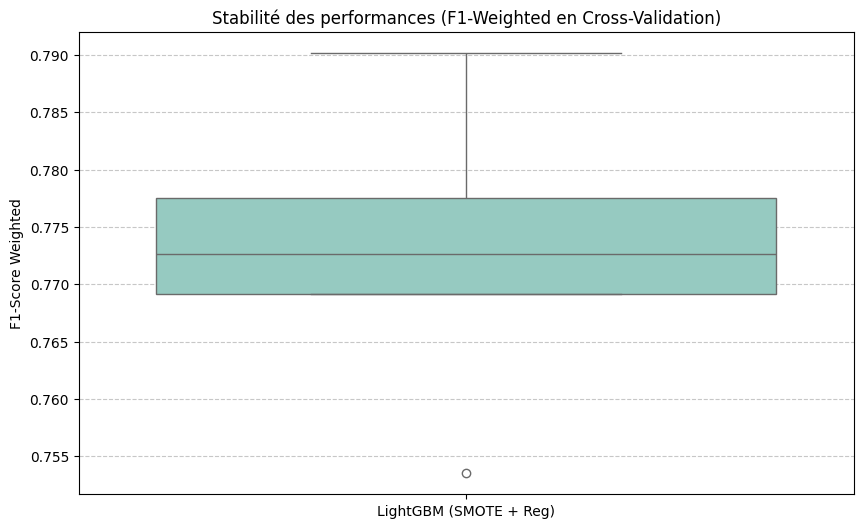

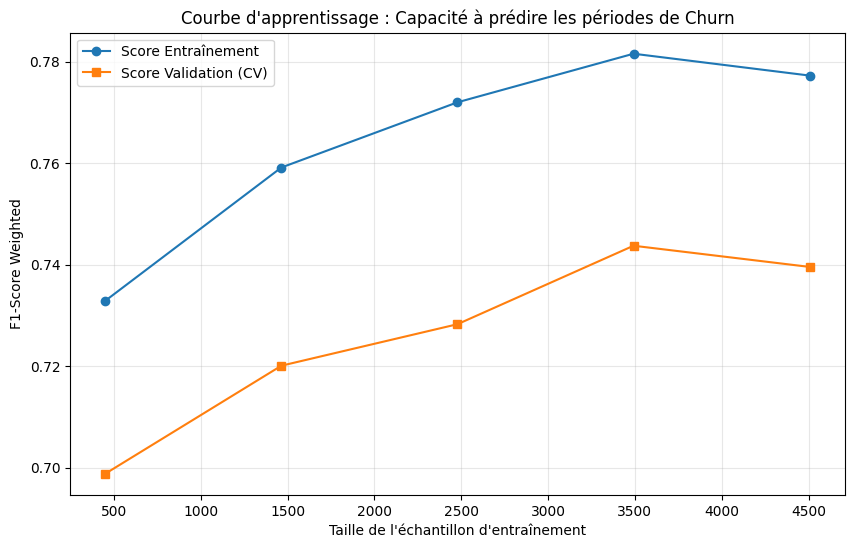

In [16]:
from sklearn.model_selection import cross_val_score, learning_curve

# --- 2. ANALYSE DE LA ROBUSTESSE (CROSS-VALIDATION) ---
cv_results = {}
# Note: On utilise 'f1_weighted'
for model in [rf_improved, lgbm_improved]:
    print(f"Calcul de la CV pour {name}...")
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
    cv_results[name] = scores

    cv_df = pd.DataFrame(cv_results)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=cv_df, palette='Set3')
    plt.title('Stabilité des performances (F1-Weighted en Cross-Validation)')
    plt.ylabel('F1-Score Weighted')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# --- 3. COURBE D'APPRENTISSAGE (LEARNING CURVE) ---
train_sizes, train_scores, test_scores = learning_curve(
    rf_improved, X_train, y_train, cv=5, 
    scoring='f1_weighted', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Score Entraînement')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 's-', label='Score Validation (CV)')
plt.title('Courbe d\'apprentissage : Capacité à prédire les périodes de Churn')
plt.xlabel('Taille de l\'échantillon d\'entraînement')
plt.ylabel('F1-Score Weighted')
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.show()

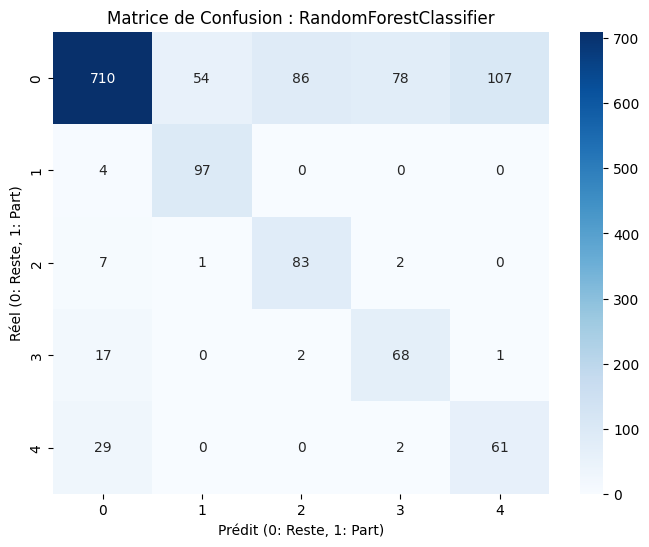

On a raté 4 clients qui sont partis sans qu'on les aide.
On a fait 54 cadeaux inutiles à des clients qui n'allaient pas partir.


In [20]:
from sklearn.metrics import confusion_matrix

# Calcul pour le meilleur modèle (LightGBM)
best_model = rf_improved
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matrice de Confusion : {type(best_model).__name__}")
plt.ylabel('Réel (0: Reste, 1: Part)')
plt.xlabel('Prédit (0: Reste, 1: Part)')
plt.show()

# Analyse métier rapide
fn = cm[1, 0] # Faux Négatifs
fp = cm[0, 1] # Faux Positifs
print(f"On a raté {fn} clients qui sont partis sans qu'on les aide.")
print(f"On a fait {fp} cadeaux inutiles à des clients qui n'allaient pas partir.")

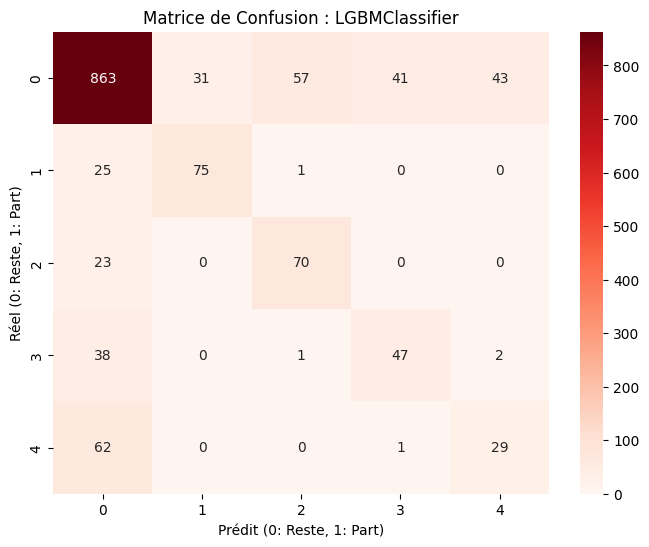

On a raté 25 clients qui sont partis sans qu'on les aide.
On a fait 31 cadeaux inutiles à des clients qui n'allaient pas partir.


In [18]:
from sklearn.metrics import confusion_matrix

# Calcul pour le meilleur modèle (LightGBM)
best_model = lgbm_improved
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title(f"Matrice de Confusion : {type(best_model).__name__}")
plt.ylabel('Réel (0: Reste, 1: Part)')
plt.xlabel('Prédit (0: Reste, 1: Part)')
plt.show()

# Analyse métier rapide
fn = cm[1, 0] # Faux Négatifs
fp = cm[0, 1] # Faux Positifs
print(f"On a raté {fn} clients qui sont partis sans qu'on les aide.")
print(f"On a fait {fp} cadeaux inutiles à des clients qui n'allaient pas partir.")

C:\Users\sppre\AppData\Local\Temp\ipykernel_33784\1476242997.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


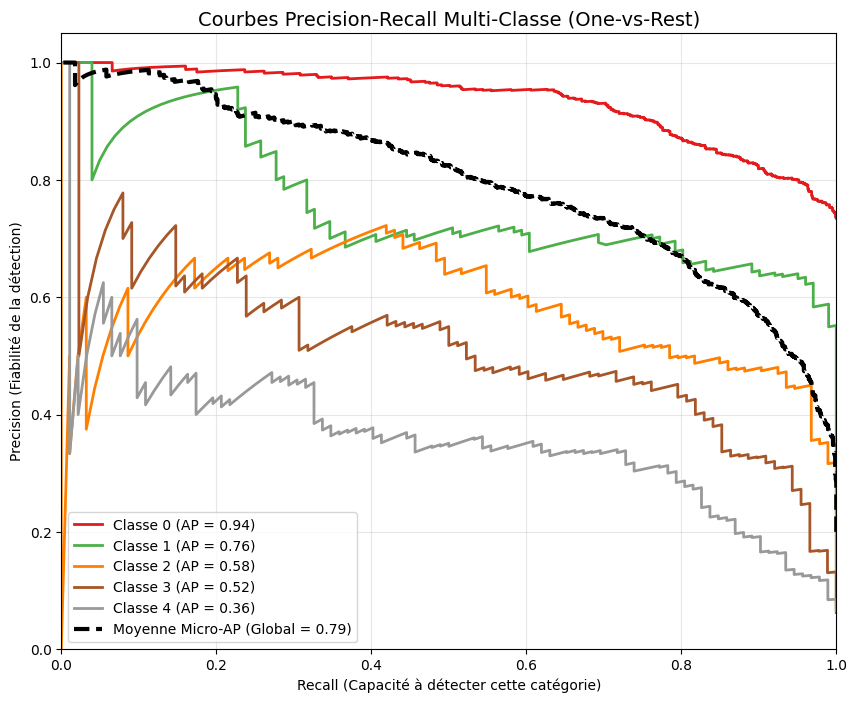

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# 1. Préparation des données
# On binarise y_test pour le format multi-classe (ex: [0, 1, 2, 3, 4])
classes = np.unique(y_test)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)
y_prob = rf_improved.predict_proba(X_test) # Probabilités pour chaque classe

# 2. Configuration du graphique
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1', n_classes)

# 3. Calcul et tracé pour chaque classe
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    avg_p = average_precision_score(y_test_bin[:, i], y_prob[:, i])
    
    # Nom de la classe pour la légende (ex: Churn 3 mois)
    label_name = f'Classe {classes[i]}' 
    
    plt.plot(recall, precision, color=colors(i), lw=2,
             label=f'{label_name} (AP = {avg_p:.2f})')

# 4. Ajout de la moyenne "Micro" (Performance globale sur toutes les classes)
precision_micro, recall_micro, _ = precision_recall_curve(y_test_bin.ravel(), y_prob.ravel())
avg_p_micro = average_precision_score(y_test_bin, y_prob, average="micro")

plt.plot(recall_micro, precision_micro, color='black', linestyle='--', lw=3,
         label=f'Moyenne Micro-AP (Global = {avg_p_micro:.2f})')

# 5. Cosmétique
plt.xlabel('Recall (Capacité à détecter cette catégorie)')
plt.ylabel('Precision (Fiabilité de la détection)')
plt.title('Courbes Precision-Recall Multi-Classe (One-vs-Rest)', fontsize=14)
plt.legend(loc='lower left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

# Rapport d'Analyse : Impact du SMOTE sur les Modèles

Suite à l'application de la méthode **SMOTE** et à l'ajustement de la régularisation, voici une comparaison des performances entre le **Random Forest** et le **LightGBM**.

---

## Comparaison des Métriques Globales

| Métrique | Random Forest (Aggressif) | LightGBM (Équilibré) |
| :--- | :---: | :---: |
| **Accuracy Globale** | 72% | **78%** |
| **Recall (Moyen)** | **80%** | 65% |
| **Précision (Moyenne)** | 57% | **62%** |
| **F1-Score (Moyen)** | **64%** | 63% |

---

## Observations Clés

### Random Forest : L'expert du Rappel
L'effet du **SMOTE** est massif sur ce modèle. Il devient extrêmement sensible aux classes minoritaires :
* **Recall impressionnant :** **95%** sur la classe 1 et **81%** sur la classe 3. Le modèle ne "manque" quasiment aucun cas de ces classes rares.
* **Contrepartie sur la Précision :** Cette sensibilité génère beaucoup de "fausses alertes". Pour la classe 4, la précision chute à **37%**, signifiant que beaucoup de prédictions positives sont en réalité des erreurs.



### LightGBM : La force de la stabilité
Le modèle LightGBM s'est montré plus robuste face à l'introduction de données synthétiques :
* **Meilleure fiabilité :** Il conserve une précision supérieure sur la classe majoritaire (0), ce qui lui permet d'afficher une **Accuracy globale de 78%**.
* **Équilibre :** Il est moins "perturbé" par le bruit potentiel généré par SMOTE que le Random Forest.

###  La Classe 4 : Le maillon faible
C'est la classe la plus complexe pour les deux algorithmes. Malgré l'équilibrage parfait des données (SMOTE) :
* Le **F1-score** reste bas pour cette catégorie.
* **Hypothèse :** Les caractéristiques (*features*) de la classe 4 se confondent probablement avec celles des autres classes (chevauchement dans l'espace des données), rendant la séparation mathématique difficile.

---

##  Conclusion
Si la priorité est de **ne rater aucun cas minoritaire** (quitte à avoir des faux positifs), le **Random Forest** est préférable. Si on cherche un **compromis plus fiable** pour la production, le **LightGBM** est le meilleur candidat.